In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torchvision.datasets.mnist import MNIST
from torchvision.datasets import STL10
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import timm
from utils import *
source_folder = 'source'

# Set seed
seed = 1
batch_size =  128
# Define mean and std from ImageNet data
in_mean = [0.485, 0.456, 0.406]
in_std = [0.229, 0.224, 0.225]

In [ ]:
import litdata
from torch import nn
import torchvision.transforms as T
import torchvision.transforms.functional as F

class ToRGBTensor:

    def __call__(self, img):
        return F.to_tensor(img).expand(3, -1, -1) # Expand to 3 channels

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"
#Loads in data and returns the dataloader


datapath = '/projects/ec232/data/'

# Define postprocessing / transform of data modalities
postprocess = (
    T.Compose([                        # Handles processing of the .jpg image
    ToRGBTensor(),
    T.Resize((224,224), antialias=None),# Convert from PIL image to RGB torch.Tensor.
    T.Normalize(in_mean, in_std),  # Normalize image to correct mean/std.
]),
nn.Identity(),
)

# Load training and validation data
traindata = litdata.LITDataset('ImageWoof', datapath).map_tuple(*postprocess)
valdata = litdata.LITDataset('ImageWoof', datapath, train=False).map_tuple(*postprocess)

# Make and return the dataloaders
train_dataloader = DataLoader(traindata, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(valdata, shuffle=False, batch_size=batch_size)





Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


input size images torch.Size([224, 224, 3])


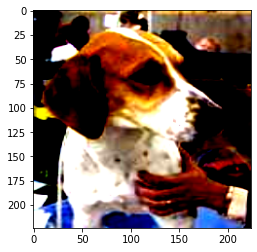

In [ ]:
" Visualization of dataset"
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

image_data = np.transpose(images[0], (1, 2, 0))

plt.imshow(image_data)
print("input size images",image_data.shape)

In [ ]:
num_classes = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:

# Load ViT model with pretrained weighs
model = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=num_classes).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
import time

# Define a function to save the model
def save_best_model(model, optimizer, epoch, loss, accuracy):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy
    }
    torch.save(state, 'best_model_woof.pth')

num_epochs = 5
best_loss = float('inf')  # Initialize with a high value
best_accuracy = 0.0  # Initialize with a low value
loss_criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = Adam(model.parameters(), lr=learning_rate)

model.train()

# Record the start time
start_time = time.time()

for epoch in range(num_epochs):
    train_loss, total_samples, train_acc = 0.0, 0.0, 0.0

    train_bar = tqdm(iterable=train_dataloader)
    for i, batch in enumerate(train_bar):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = loss_criterion(y_hat, y)

        train_loss += loss.item()
        total_samples += len(x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_hat, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_hat)
        train_bar.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        train_bar.set_postfix(loss=train_loss / total_samples)

    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss / total_samples
    avg_accuracy = train_acc / total_samples * 100

    print(f'Train loss: {avg_loss:.4f}')
    print(f'Train accuracy: {avg_accuracy:.2f}%')

    # Check if this is the best model so far based on validation loss
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_accuracy = avg_accuracy
        save_best_model(model, optimizer, epoch, best_loss, best_accuracy)

# Record the end time
end_time = time.time()

# Calculate the total training time
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")


In [ ]:
# Test evaluation
model.eval()
with torch.no_grad():
    test_loss, correct_pred, total_samples = 0.0, 0.0, 0.0

    test_bar = tqdm(iterable=val_dataloader)
    for i, batch in enumerate(test_bar):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model_lora(x)
        loss = loss_criterion(y_hat, y)

        test_loss += loss.detach().cpu().item()
        correct_pred += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total_samples += len(x)

        test_bar.set_description(f'Test loop')
        test_bar.set_postfix(loss = test_loss / total_samples)

print(f'Test loss: {test_loss / total_samples:.4f}')
print(f'Test accuracy: {correct_pred / total_samples * 100:.2f}%')

In [ ]:
class LoRAWrapper(nn.Module):

    def __init__(self, linear, rank):
        super().__init__()
        assert isinstance(linear, nn.Linear)

        # Save original weight and bias
        self.register_buffer('orig_weight', linear.weight.data.cpu())
        if linear.bias is not None:
            self.register_buffer('orig_bias', linear.bias.data.cpu())
        else:
            self.register_buffer('orig_bias', None)

        # Save the parameters you might need...
        self.in_dim = linear.in_features
        self.out_dim = linear.out_features
        self.bias = linear.bias is not None
        self.rank = rank

        # Initialize the A and B weights.

        self.lora_linear = nn.Sequential(
            nn.Linear(self.in_dim, rank, bias=False),
            nn.Linear(rank, self.out_dim, bias=self.bias)
        ).to(device)

        # Make sure the A weights are initialized with Gaussian random noise
        nn.init.normal_(self.lora_linear[0].weight.data, mean=0, std=0.01)

        # Make sure the B weights are initialized with zeros
        if self.bias:
            nn.init.zeros_(self.lora_linear[1].weight.data)
            nn.init.zeros_(self.lora_linear[1].bias.data)
        #self.A = nn.Parameter(torch.zeros(self.rank, self.out_dim).to(device))
        #self.B = nn.Parameter(torch.zeros(self.in_dim,self.rank).to(device))

        #nn.init.normal_(self.A.weight,mean=0,std=1)
        #nn.init.zeros_(self.B.weight)

    def forward(self, x):

        W_0 = torch.matmul(x.to(device), self.orig_weight.t().to(device))

        if self.bias:
            W_0 += self.orig_bias.to(device)

        # A * x
        A_x = self.lora_linear[0](x)

        # B * A * x
        BA_x = self.lora_linear[1](A_x)

        output = W_0 + BA_x

        return output

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The number of classes in the dataset we want to finetune on
num_classes = 10

# Load ViT model with pretrained weighs
model_lora_new = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=num_classes).to(device)


In [ ]:
# Freeze all layers except classification head
for name, param in model_lora_new.named_parameters():
    if name in ['norm.weight', 'norm.bias', 'head.weight', 'head.bias']:
        param.requires_grad = True
    else:
        param.requires_grad = False


# LoRA wrapper
for block in model_lora_new.blocks:

    # Wrap linear layers in the attention block

    block.attn.qkv = LoRAWrapper(block.attn.qkv, rank=12)
    block.attn.proj = LoRAWrapper(block.attn.proj, rank = 12)

    # Unfreeze the attention block
    block.attn.requires_grad_(True)

    # Unfreeze LayerScale layers as well
    block.ls1.requires_grad_(True)
    block.ls2.requires_grad_(True)

In [ ]:
# Define a function to save the model≈
def save_best_model(model, optimizer, epoch, loss, accuracy):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy
    }
    torch.save(state, 'best_model_woof_lora.pth')

# Train ViT with LoRA wrapper

num_epochs = 5
learning_rate = 1e-4

import time  # Import the time module

loss_criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = Adam(model_lora_new.parameters(), lr=learning_rate)
best_loss = float('inf')
model_lora_new.train()


# Record the start time
start_time = time.time()

for epoch in range(num_epochs):
    train_loss, total_samples,train_acc = 0.0, 0.0, 0.0

    train_bar = tqdm(iterable=train_dataloader)
    for i, batch in enumerate(train_bar):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model_lora_new(x)
        loss = loss_criterion(y_hat, y)

        train_loss += loss.item()
        total_samples += len(x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_hat, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_hat)
        train_bar.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        train_bar.set_postfix(loss = train_loss / total_samples)

    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss / total_samples
    avg_accuracy = train_acc / total_samples * 100

    print(f'Train loss: {avg_loss:.4f}')
    print(f'Train accuracy: {avg_accuracy:.2f}%')

    # Check if this is the best model so far based on validation loss
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_accuracy = avg_accuracy
        save_best_model(model_lora_new, optimizer, epoch, best_loss, best_accuracy)

# Record the end time
end_time = time.time()

# Calculate the total training time
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")



Epoch [1/5]:   1%|▏         | 1/71 [00:42<49:19, 42.28s/it, loss=0.0223]